1/1 [==============================] - 0s 148ms/step


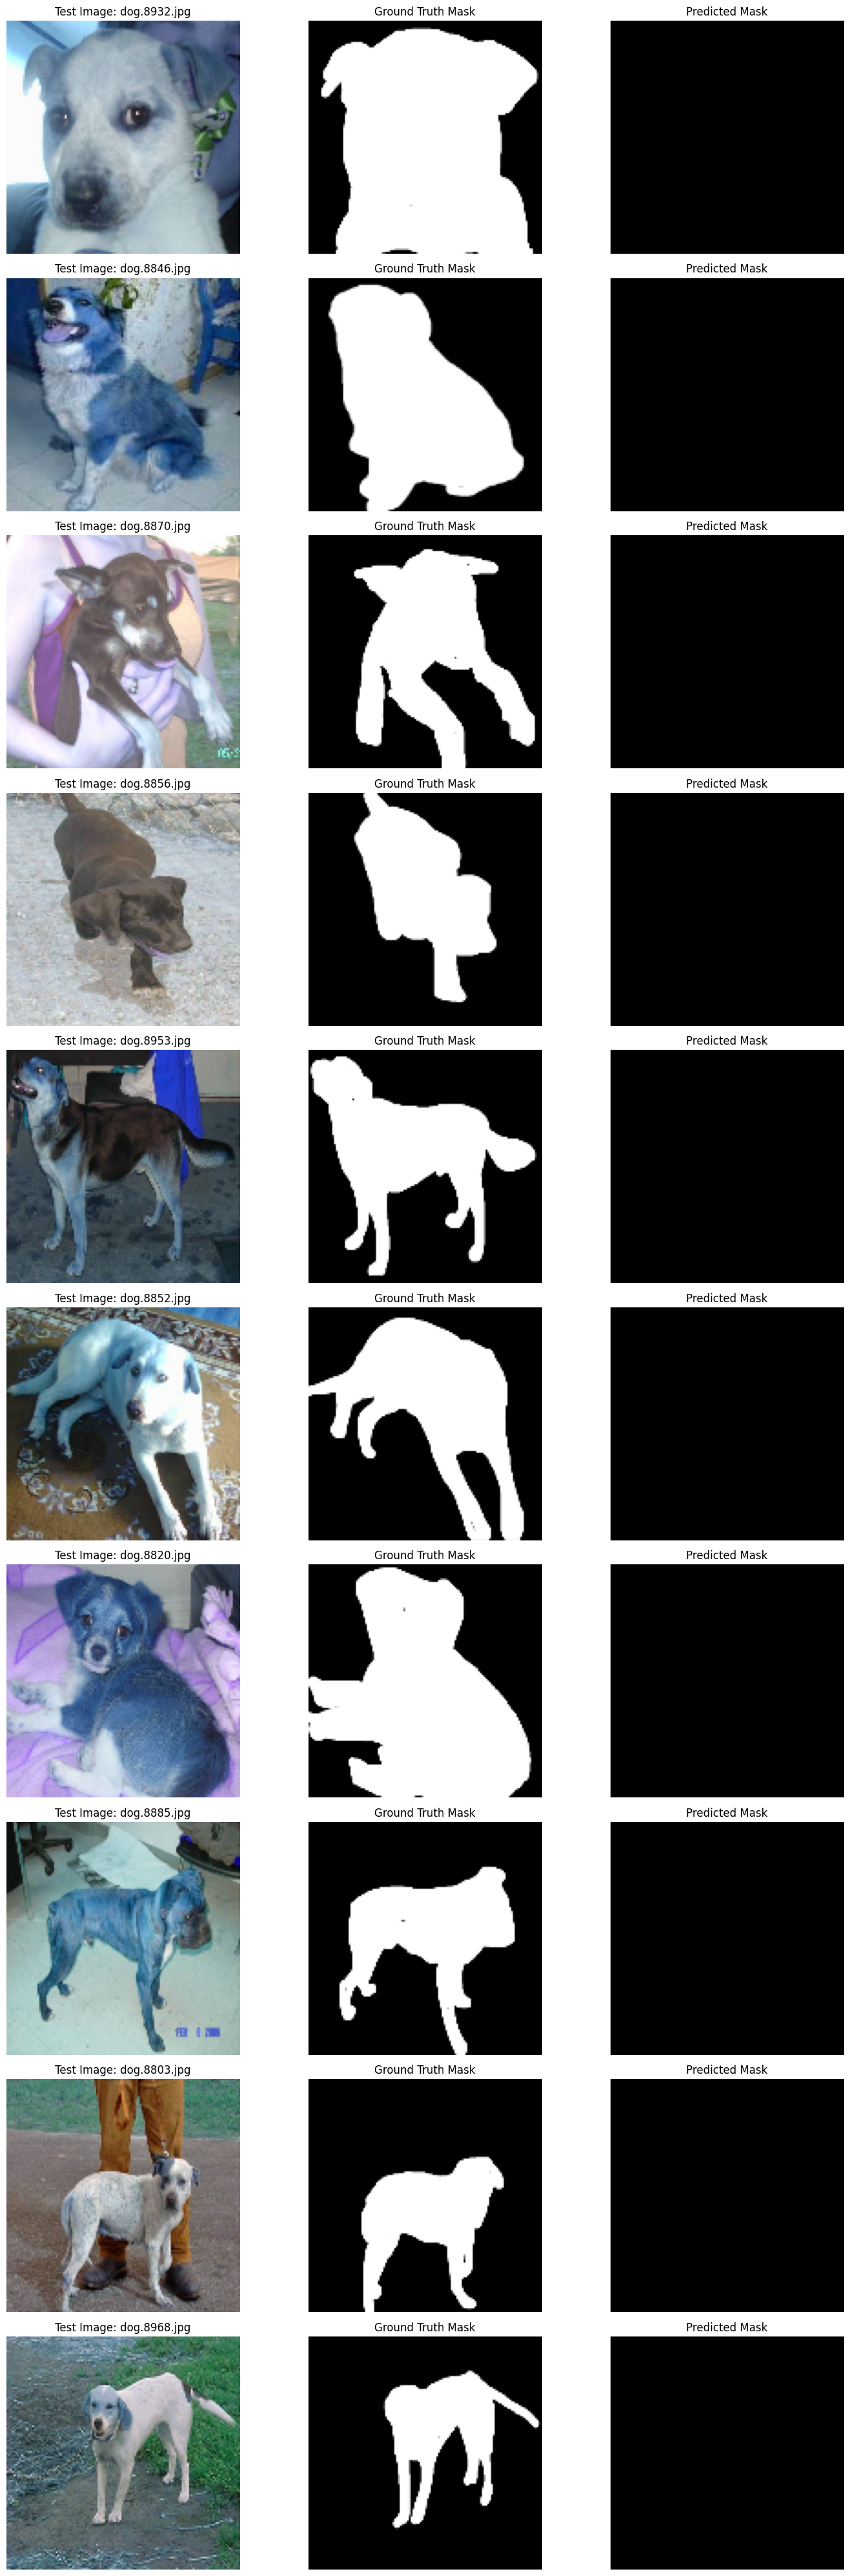

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Loading and Preprocessing
def load_and_preprocess_data(image_dir, mask_dir, img_size=(128, 128)):  # Reduced image size
    images = []
    masks = []
    filenames = []
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, f"annotated_{img_name}")
        
        if os.path.exists(mask_path):
            # Read and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize
            
            # Read and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize
            mask = np.expand_dims(mask, axis=-1)
            
            images.append(img)
            masks.append(mask)
            filenames.append(img_name)
    
    return np.array(images), np.array(masks), filenames

# Minimal U-Net Model Definition
def build_minimal_unet(input_shape=(128, 128, 3)):  # Updated for smaller input size
    inputs = layers.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bridge
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    
    # Expansive Path (Decoder)
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    
    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Training Function
def train_model(model, X_train, y_train, X_val, y_val, batch_size=8, epochs=1):
    model.compile(
        optimizer=Adam(learning_rate=0.005),  # Adam optimizer
        loss='binary_crossentropy',          # Binary crossentropy loss
        metrics=['accuracy']                 # Accuracy as a metric
    )
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
        ]
    )
    return history
    
# Main function
# Update main function to use the correct U-Net builder
def main():
    image_dir = r"C:\Users\Manthan\Desktop\CV_DL_Practicals\dog\Dog Segmentation\Images"
    mask_dir = r"C:\Users\Manthan\Desktop\CV_DL_Practicals\dog\Dog Segmentation\Labels"
    
    # Load and preprocess data
    images, masks, filenames = load_and_preprocess_data(image_dir, mask_dir)
    
    # Reserve 10 images for testing
    test_size = 10
    test_indices = np.random.choice(len(images), test_size, replace=False)
    
    test_images = images[test_indices]
    test_masks = masks[test_indices]
    test_filenames = [filenames[i] for i in test_indices]
   
    # Remaining for training
    train_indices = list(set(range(len(images))) - set(test_indices))
    train_images = images[train_indices]
    train_masks = masks[train_indices]
    
    with tf.device('/CPU:0'):  # Or '/CPU:0' to force CPU
        model = build_minimal_unet(input_shape=(128, 128, 3))  # Correct input shape
    
    # Train model
    history = train_model(model, train_images, train_masks, test_images, test_masks)
    
    # Save the model
    # model.save('dog_segmentation_model.h5')
    predicted_masks = model.predict(test_images)
    predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Threshold predictions
    
    # Display 10 test images and their corresponding masks
    fig, axes = plt.subplots(test_size, 3, figsize=(15, 40))
    for i, (img, true_mask, pred_mask, fname) in enumerate(zip(test_images, test_masks, predicted_masks, test_filenames)):
        # Display test image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Test Image: {fname}")
        axes[i, 0].axis('off')
        
        # Display ground truth mask
        axes[i, 1].imshow(true_mask.squeeze(), cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis('off')
        
        # Display predicted mask
        axes[i, 2].imshow(pred_mask.squeeze(), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()